### Functions

In [ ]:
fontsize = 13

##### Initialization

In [ ]:
# Base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)

# Convert currencies
#!pip install currencyconverter
#from currency_converter import CurrencyConverter

# Convert strings with commas as thousand separators
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') 

# Convert datatimes
from datetime import datetime

# Read zips
from zipfile import ZipFile

# Forecast models
#!pip install statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

# Warnings
import warnings

def mount_drive_select_path(drive_path = "/content/drive/MyDrive/UA/5º Ano/Tese"):

  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Drive path
  %cd $drive_path

##### Read data

In [ ]:
def zip_2_dataframe(zip_name, file_name, filetype):
  
  # Open zip file
  zip_file = ZipFile(zip_name, 'r')  

  # Open file
  data_file = zip_file.open(file_name)

  if filetype == "csv":
    df = pd.read_csv(data_file)
  if filetype == "json":
    df = pd.read_json(data_file, lines=True)

  return df

##### Data cleaning

In [ ]:
# Convert a string to datetime data format
def str_2_date(str_date, date_format):
  return datetime.strptime(str(str_date), date_format)

# Replace the last ocurrence of a char in a string by another char
def replace_last_occurrence(str, old_char, new_char):
  
  last_index = str.rfind(old_char)
  if last_index == -1:    # the char wasn't found
    return str
  else:
    return str[:last_index] + new_char + str[last_index+1:]


# Remove commas, dots and currency signs from the prices
def clean_prices(price):

  # Sol peruano (doesn't have decimal cases - thousands are separated with commas)
  if price[0] == "S":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[2:])                              # remove the sign of the currency
    return price
  
  # Dollar (always has decimal cases (i think) - thousands and decimals are both separated by commas)
  if price[0] == "$":
    price = replace_last_occurrence(price, ",", ".")      # replace comma that separates decimals by a dot
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price
  
  # Euro (decimal cases, if there are any, are separated by dots - thousands are separated by commas)
  if price[0] == "€":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price                              
  
  return np.nan


# Convert all prices to a base currency (euro)
def convert_prices_to_euros(row, currency_column, price_column, sol = 0.24, dollar = 1/1.0993):

  currency = row[currency_column]
  price = row[price_column]
  
  if currency in ["€"]:
    return price

  if currency in ["$"]:
    return dollar*price 
  
  if currency in ["S"]:
    return sol*price 


def clean_data(df):

  df = df.copy()
  
  # Convert timestamps' strings to data of date format
  df["timestamp"] = df["timestamp"].apply(str_2_date, args = ('%Y%m%d',))

  # Get type of currency
  df["currency"] = df["price"].str[0]

  # Clean prices (remove commas, dots, and currency signs)
  df["price_clean"] = df["price"].apply(clean_prices)

  # Convert all prices to a base currency (euro)
  df["price_euro"] = df.apply(convert_prices_to_euros, args = ("currency", "price_clean"), axis = 1)

  return df

##### Select time series

In [ ]:
# Select a particular time series based on its ID - ID can be of type: product_id, product_group_id, company_id

def select_time_series(df, id_type, id, price = "price_euro"):

  df = df.copy()

  # Select all rows that have id
  df = df[df[id_type].isin(id)]
  
  # Information about the selected products
  info = {
      "product_id": list(df["product_id"].unique()),
      "product_group_id": list(df["product_group_id"].unique()),
      "company_id": list(df["company_id"].unique()),
      "product": list(df["product"].unique()),
      "country_company": list(df["country_company"].unique()),
      "offer_type": list(df["offer_type"].unique())
      }
  
  return df, info

##### Transform data series

In [ ]:
# Apply differences to a time series
def diff_time_series(df, diff_order, columns = "all"):
  
  # diff_order - how many times data must be differenced
  # columns - list of the names of columns that will be differenced

  df = df.copy()

  if columns == "all":
    columns = df.columns

  for order in range(diff_order):
    df[columns] = df[columns].diff()
  
  df = df.dropna()

  return df

Add unique identifiers to data

In [ ]:
def create_id(df, id_name, unique_identifiers, loc = 0):
  df = df.copy()
  df.insert(loc=loc, column=id_name, value=df.set_index(unique_identifiers).index.factorize()[0]+1)
  return df

def add_ids(df):
  df = df.copy()

  df = create_id(df, "product_id", ['company','country','product','offer_type'])
  df = create_id(df, 'product_group_id', ['product','offer_type'])
  df = create_id(df, 'company_id', ['company','country'])
  df.insert(loc=0, column='country_company', value= df.country + " " + df.company)

  return df

Order time series by number of changes

In [ ]:
def get_ordered_number_of_changes(df):
  
  df_changes = pd.DataFrame({'n_changes' : df.groupby('product_id')['price_clean'].nunique()}).reset_index().sort_values(by = "n_changes", ascending = False)  
  product_id_ord = df_changes["product_id"].to_numpy()

  return df_changes, product_id_ord

Missing values

In [ ]:
def add_stock_info(df, price = "price_euro"):
  df = df.copy()
  df["days_out_of_stock"] = df[price].isna().astype(int).groupby(df[price].notnull().astype(int).cumsum()).cumsum()
  df["out_of_stock"] = df[price].isna().astype(int)
  return df

# Add the days that are not present in a certain time series
def fill_miss_vals(df, time_column_name = "timestamp"):

  # df - data of a single time series
  # time_column_name - name of the column with the information of timestamps

  df = df.copy()

  idx = pd.date_range(min(df.index), max(df.index))
  df = df.reindex(idx, fill_value=np.nan)
  df.index.name = time_column_name

  return df

# Interpolation
def interpolate(df, method):
  return df.copy().interpolate(method =method, limit_direction ='forward')  

##### Visualize data

In [ ]:
# Set size of plot
def set_fig_size(size):
  plt.rcParams['figure.figsize'] = size

# Plot the time series of individual products
def show_time_series_product(df, info, price):
  
  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o')
  
  if len(product_id) == 1:
    ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
    print("Number of samples: ", len(df))

# Plot the time series of all products that belong to a certain group
def show_time_series_product_group(df, info, price):

  df = df.copy()

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "country_company", data=df, marker = 'o')
  ax.set_title(info["product"][0] + " - " + info["offer_type"][0]);

# Plot the time series that belong to a certain company from a certain country
def show_time_series_country_company(df, info, price):

  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o', legend = False)
  ax.set_title(info["country_company"][0]);


def show_time_series(df, id_type, info, price = "price_euro"):

  df = df.copy()
  
  if id_type == "product_id":
    show_time_series_product(df, info, price)
  if id_type == "product_group_id":
    show_time_series_product_group(df, info, price)
  if id_type == "company_id":
    show_time_series_country_company(df, info, price)

In [ ]:
mount_drive_select_path()

Mounted at /content/drive
/content/drive/MyDrive/UA/5º Ano/Tese


##### Read data

In [ ]:
zip_name = "data/catalog_sample.zip"
file_name = "catalog_sample.json"
filetype = "json"
df_og = zip_2_dataframe(zip_name, file_name, filetype)

##### Save fig

In [ ]:
def save_fig(plt, chapter_name, section_name, name_of_fig):
  path = 'Dissertação/Chapters/Imagens/Chapter_' + chapter_name + "/" + str.lower(chapter_name) + "_" + str.lower(section_name) + "_" + name_of_fig + "."
  print(path)
  plt.savefig(path + "svg")
  plt.savefig(path + "png", bbox_inches = "tight")
  plt.savefig(path + "pdf")

# Notebook: Exploratory Analysis

- **Goal**: exploratory analysis of the data to deal with missing values (this time using interpolation) and find the distribution of time series per country and company

In [ ]:
mount_drive_select_path()

Mounted at /content/drive
/content/drive/MyDrive/UA/5º Ano/Tese


## Prepare Data

##### Data Cleaning

In [ ]:
df = df_og.copy()

- Convert elements of timestamp column to dates:

In [ ]:
def str_2_date(str_date, date_format):
  return datetime.strptime(str(str_date), date_format)

df["timestamp"] = df_og["timestamp"].apply(str_2_date, args = ('%Y%m%d',))

- List of different currencies

There are three different types of currencies:

- Euros
- Dollars
- Sol (Peru's currency)

**Note:** To compare prices of different countries it may be useful to convert all currencies to a base currency (e.g. euro). However, there are fluctuations in the value of each currency, and so it may be better to do the analysis in each currency, but this should be further analysed.

In [ ]:
df["price"].str[0].unique()

array(['$', '€', 'S'], dtype=object)

To compare prices across different countries, a new column will be created with all prices in Euros. A column with the prices withouth commas, dots and currency signs wil also be created.

The value of each currency as stated by the Europen Central Bank can be found in this link: https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/index.en.html).

 The Sol (Peru) currency is not present in here.

In [ ]:
def replace_last_occurrence(str, old_char, new_char):

  # Replace the last ocurrence of a char in a string by another char

  last_index = str.rfind(old_char)
  if last_index == -1:
    return str
  else:
    return str[:last_index] + new_char + str[last_index+1:]


def clean_prices(price):

  # Remove commas, dots and currency signs from the prices

  # Sol peruano (doesn't have decimal cases - thousands are separated with commas)
  if price[0] == "S":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[2:])                              # remove the sign of the currency
    return price
  
  # Dollar (always has decimal cases (i think) - thousands and decimals are both separated by commas)
  if price[0] == "$":
    price = replace_last_occurrence(price, ",", ".")      # replace comma that separates decimals by a dot
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price
  
  # Euro (decimal cases, if there are any, are separated by dots - thousands are separated by commas)
  if price[0] == "€":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price                              
  
  return np.nan

def convert_prices_to_euros(row, currency_column, price_column):

  # Convert all prices to a base currency (euro)

  currency = row[currency_column]
  price = row[price_column]

  sol = 0.24
  dollar = 1/1.0993
  
  if currency in ["€"]:
    return price

  if currency in ["$"]:
    return dollar*price 
  
  if currency in ["S"]:
    return sol*price 


# Column with type of currency
df["currency"] = df_og["price"].str[0]

# Clean prices (remove commas, dots, and currency signs)
df["price_clean"] = df_og["price"].apply(clean_prices)

# Conver prices to euros
df["price_euro"] = df.apply(convert_prices_to_euros, args = ("currency", "price_clean"), axis = 1)

##### Add unique identifiers to products, product groups and companies

In [ ]:
def create_id(df, id_name, unique_identifiers, loc = 0):
  df = df.copy()
  df.insert(loc=loc, column=id_name, value=df.set_index(unique_identifiers).index.factorize()[0]+1)
  return df

def prepare_data(df):
  df = df.copy()

  df = create_id(df, "product_id", ['company','country','product','offer_type'])
  df = create_id(df, 'product_group_id', ['product','offer_type'])
  df = create_id(df, 'company_id', ['company','country'])
  df.insert(loc=0, column='country_company', value= df.country + " " + df.company)

  return df

df = prepare_data(df)

##### Order products by number of changes in time series

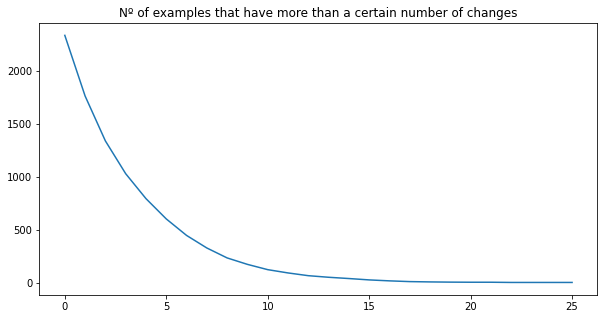

In [ ]:
def get_ordered_number_of_changes(df):
  
  df_changes = pd.DataFrame({'n_changes' : df.groupby('product_id')['price_clean'].nunique()}).reset_index().sort_values(by = "n_changes", ascending = False)  
  product_id_ord = df_changes["product_id"].to_numpy()

  return df_changes, product_id_ord


df_changes, product_id_ord = get_ordered_number_of_changes(df)

counts = []
for i in range(min(df_changes["n_changes"]), max(df_changes["n_changes"])):
  counts.append(len(df_changes[df_changes["n_changes"] > i]))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(counts)
#ax.set_yscale('log')
plt.title("Nº of examples that have more than a certain number of changes");

##### Select time series and visualize it

In [ ]:
product_id = [product_id_ord[0]]
df_product, info = select_time_series(df, "product_id", product_id)

product_group_id = info["product_group_id"]
company_id = info["company_id"]

Number of samples:  216


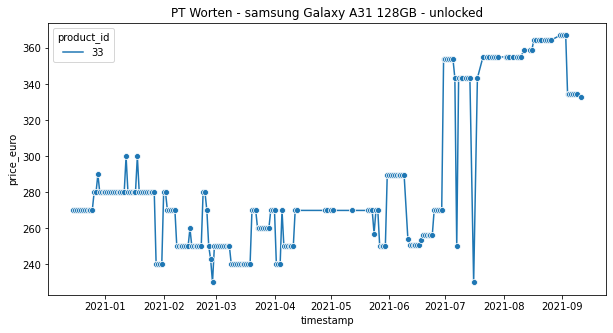

In [ ]:
show_time_series(df_product, "product_id", info)

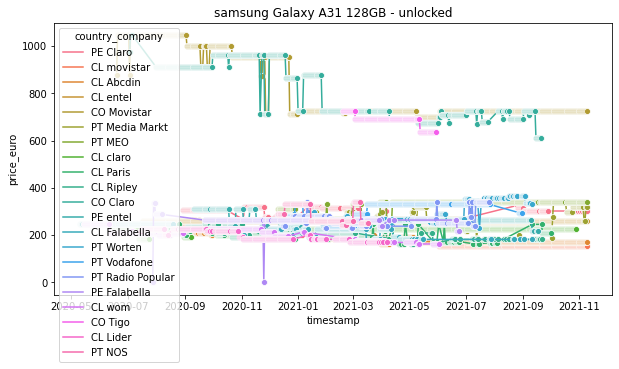

In [ ]:
df_product_group, info = select_time_series(df, "product_group_id", product_group_id)
show_time_series(df_product_group, "product_group_id", info)

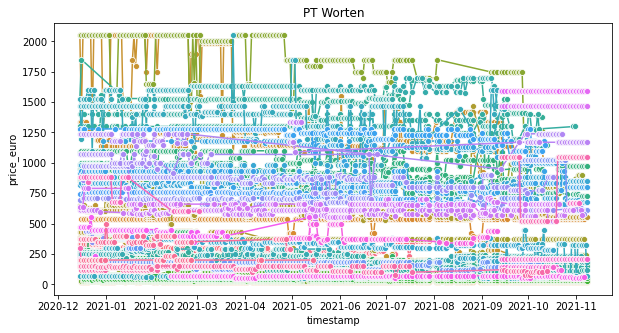

In [ ]:
df_company, info = select_time_series(df, "company_id", company_id)
show_time_series(df_company, "company_id", info)

##### Obtain exogenous variables from a time series

Obtain a variable that indicates if the products were out of stock and another variable to indicate to indicate for how many days have they been out of stock.

In [ ]:
def add_stock_info(df, price = "price_euro"):
  df = df.copy()
  df["days_out_of_stock"] = df[price].isna().astype(int).groupby(df[price].notnull().astype(int).cumsum()).cumsum()
  df["out_of_stock"] = df[price].isna().astype(int)
  return df

Show the correlation between the newly created variables.

In [ ]:
def plot_ccf(x, y, name_x, name_y, unbiased = True, ax = None):
  cross_corr = ccf(x, y, unbiased)

  if ax == None:
    plt.plot(cross_corr)
    plt.title("Cross correlation - " + name_x + " x " + name_y)
    plt.xlabel("Lags")
  else:
    ax.plot(cross_corr)
    ax.set_title("Cross correlation - " + name_x + " x " + name_y)
    ax.set(xlabel = "Lags")
  
  return cross_corr

In [ ]:
product_id = [product_id_ord[0]]
df_product, info = select_time_series(df, "product_id", product_id)
df_product = df_product[["timestamp", "price_euro"]].set_index("timestamp")

df_product = add_miss_vals(df_product)
df_product = add_stock_info(df_product)

df_product["price_euro"] = df_product["price_euro"].interpolate(method ='linear', limit_direction ='forward')

NameError: ignored

In [ ]:
set_fig_size((15, 5))
fig, ax = plt.subplots(1,2)

plot_ccf(df_product["days_out_of_stock"], df_product["price_euro"], "Days out of stock", "Price Euro", ax = ax[0]);
plot_ccf(df_product["out_of_stock"], df_product["price_euro"], "Out of stock", "Price Euro", ax = ax[1]);

## Missing values

The prices of the products aren't always retrieved in consecutive days. We believe this happens when the seller runs out of stock, which causes the price of the product to disapear from the website.

In [ ]:
# Add the days that are not present in a certain time series
def fill_miss_vals(df, time_column_name = "timestamp"):

  # df - data of a single time series
  # time_column_name - name of the column with the information of timestamps

  df = df.copy()

  idx = pd.date_range(min(df.index), max(df.index))
  df = df.reindex(idx, fill_value=np.nan)
  df.index.name = time_column_name

  return df

To guarantee the models wil work well, it may be usefull to atribute values to the missing values that were created in the previous section. This can be done in two ways: repeat the previous value or perform linear interpolation (as the data doesn't "fluctuate", linear interpolation is fine. We opted for performing just linear interpolation, as this seems more natural.

In [ ]:
product_id = [product_id_ord[202]]
df_product, info = select_time_series(df, "product_id", product_id)
df_product = df_product[["timestamp", "price_euro"]].set_index("timestamp")
df_product = fill_miss_vals(df_product)
df_product["Missing Values"] = df_product.price_euro.isna()
set_fig_size((18, 5))
fig, ax = plt.subplots(1,3)

# Original time series
sns1 = sns.scatterplot(x = "timestamp", y = "price_euro", data = df_product, marker = 'o', ax = ax[0])
sns1.set_title("No Interpolation", fontsize = fontsize)
sns1.set_ylabel("Price/€", fontsize = fontsize - 1.5)
sns1.set_xlabel("")
sns1.set_xticklabels(df_product.index.date, rotation=15, ha='right')
xticks = sns1.xaxis.get_major_ticks()
for i in range(0, len(xticks), 2):
  xticks[i].set_visible(False)

# Interpolate - Linear interpolation
df_product_interp2 = df_product.copy()
df_product_interp2["price_euro"] = df_product_interp2["price_euro"].interpolate(method ='linear', limit_direction ='forward') 
sns3 = sns.scatterplot(x = "timestamp", y = "price_euro", hue = "Missing Values", data = df_product_interp2, marker = 'o', ax = ax[1])
sns3.set_title("Linear Interpolation", fontsize = fontsize)
sns3.set_ylabel("Price/€", fontsize = fontsize - 1.5)
sns3.set_xlabel("")
sns3.set_xticklabels(df_product_interp2.index.date, rotation=15, ha='right')
xticks = sns3.xaxis.get_major_ticks()
for i in range(0, len(xticks), 2):
  xticks[i].set_visible(False)

# Interpolate - Repeat latest sample
df_product_interp1 = df_product.copy()
df_product_interp1["price_euro"] = df_product_interp1["price_euro"].interpolate(method ='ffill', limit_direction ='forward') 
sns2 = sns.scatterplot(x = "timestamp", y = "price_euro", hue = "Missing Values", data = df_product_interp1, marker = 'o', ax = ax[2])
sns2.set_title("Naive Interpolation (repeat last sample)", fontsize = fontsize)
sns2.set_ylabel("Price/€", fontsize = fontsize - 1.5)
sns2.set_xlabel("")
sns2.set_xticklabels(df_product_interp1.index.date, rotation=12, ha='right');
xticks = sns2.xaxis.get_major_ticks()
for i in range(0, len(xticks), 2):
  xticks[i].set_visible(False)

#save_fig(plt, chapter_name = "Data", section_name = "missingValues", name_of_fig = "interpolationTypes")

SyntaxError: ignored

## Data analysis

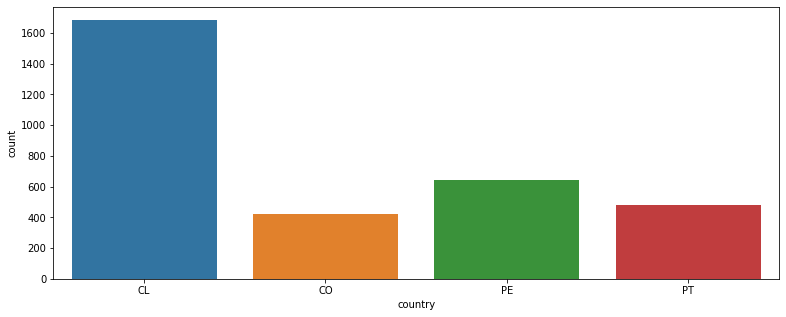

In [ ]:
a = df.groupby(by = "product_id")
a = df.drop_duplicates(subset=['product_id'])
a = a.sort_values("country")
sns.countplot(data = a, x = "country")

Dissertação/Chapters/Imagens/Chapter_Data/data_dataset_distributionTimeSeriesCompanyCountry.


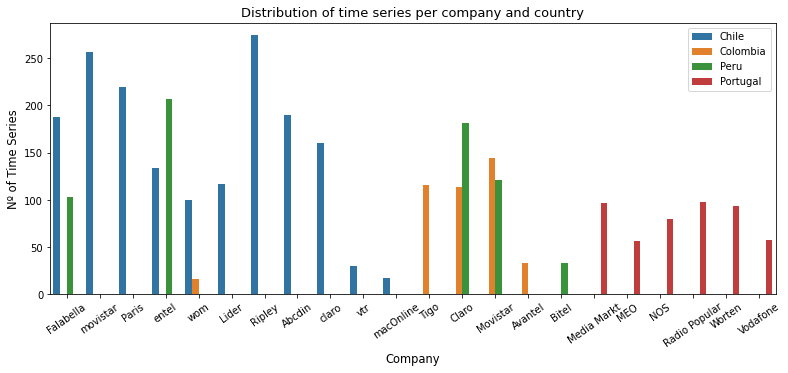

In [ ]:
set_fig_size((13, 5))
sns.countplot(data = a, x = "company", hue = "country")
plt.legend(loc='upper right', labels=['Chile', 'Colombia', 'Peru', 'Portugal'])
plt.xticks(rotation=35)
plt.xlabel("Company", fontsize = fontsize - 1.5)
plt.ylabel("Nº of Time Series", fontsize = fontsize - 1.5)
plt.title("Distribution of time series per company and country", fontsize = fontsize)
save_fig(plt, chapter_name = "Data", section_name = "dataset", name_of_fig = "distributionTimeSeriesCompanyCountry")

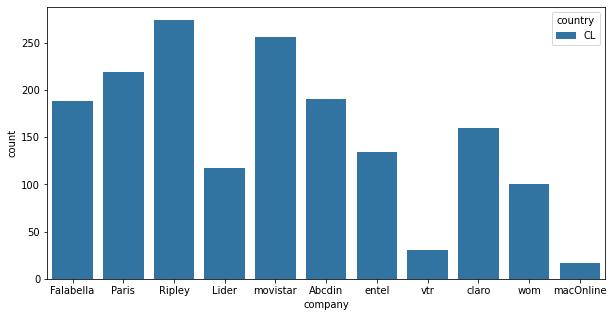

In [ ]:
sns.countplot(data = a[a["country"] == "CL"], x = "company", hue = "country")

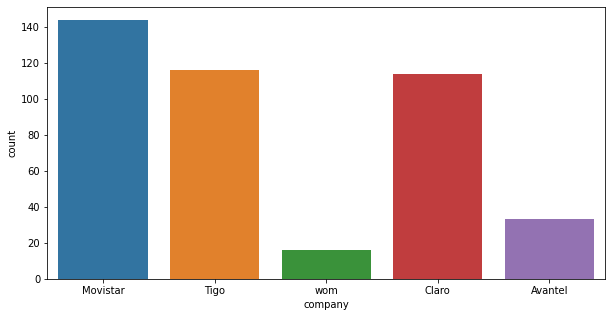

In [ ]:
sns.countplot(data = a[a["country"] == "CO"], x = "company")

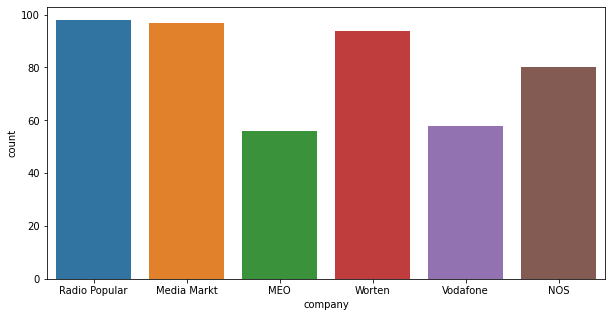

In [ ]:
sns.countplot(data = a[a["country"] == "PT"], x = "company")